---
<h1 align="center"><strong>Semantic Similarity CamemBERT</strong><h1>

<h2 align="center"><b>---Bi-Encoder---<h2>

---

In [ ]:
!pip install transformers -q
!pip install SentencePiece -q
!pip install datasets -q

     |████████████████████████████████| 4.4 MB 14.7 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 6.6 MB 59.0 MB/s 
     |████████████████████████████████| 596 kB 66.9 MB/s 
     |████████████████████████████████| 1.2 MB 14.4 MB/s 
     |████████████████████████████████| 362 kB 11.3 MB/s 
     |████████████████████████████████| 212 kB 18.6 MB/s 
     |████████████████████████████████| 140 kB 58.0 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
     |████████████████████████████████| 127 kB 56.6 MB/s 
     |████████████████████████████████| 271 kB 56.9 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 144 kB 57.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which 

### Required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import model_selection, metrics

from tqdm import tqdm
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")
import scipy

### Utils

In [ ]:
def convert_dataset(dataset):
  dataset_samples= pd.DataFrame(columns = ["sentence1","sentence2", "similarity_score"])
  for df in dataset:
    score = float(df['similarity_score'])/5.0
    dataset_samples = dataset_samples.append(df, ignore_index = True)
  dataset_samples['similarity_score']= dataset_samples.apply(lambda col: float(col.similarity_score)/5.0, axis=1)
  return dataset_samples

def get_sts_df(df_train, df_valid, df_test):
  train_samples = convert_dataset(df_train)
  dev_samples = convert_dataset(df_valid)
  test_samples = convert_dataset(df_test)

  #df = pd.concat([train_samples, dev_samples, test_samples], axis=0)
  df = pd.concat([train_samples, dev_samples], axis=0)
  df.reset_index(drop=True, inplace=True)
  #df["similarity_score"] = df["similarity_score"].apply(lambda score: 1 if score> 0.5 else 0)
  return df, test_samples

In [ ]:
df_train = load_dataset("stsb_multi_mt", name="fr", split="train")
df_valid = load_dataset("stsb_multi_mt", name="fr", split="dev")
df_test = load_dataset("stsb_multi_mt", name="fr", split="test")

df,test_samples  = get_sts_df(df_train, df_valid, df_test)
df.to_csv("sts.csv")

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


In [ ]:
class Config:
  MAX_LEN = 64
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 2
  DEVICE = torch.device("cuda") #if torch.cuda.is_available() else "cpu")

  CamemeBERT_PATH = "camembert-base"
  MODEL_PATH = "stscamembertModel.bin"
  TRAINING_DATA = "sts.csv"

  TOKENIZER = transformers.CamembertTokenizer.from_pretrained(CamemeBERT_PATH, do_lower_case = True)
  MODEL = transformers.CamembertModel.from_pretrained(CamemeBERT_PATH, return_dict=False)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Dataset

In [ ]:
class DataProcess:
  def __init__(self, sent1, sent2):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN

    self.sent1 = sent1
    self.sent2 = sent2
    
  def preprocess_bert(self):
    sent1 = " ".join(self.sent1.split())
    sent2 = " ".join(self.sent2.split())

    inputs1 = self.tokenizer.encode_plus(
        sent1,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )
    
    inputs2 = self.tokenizer.encode_plus(
        sent2,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids1 = inputs1["input_ids"]
    attention_mask1 = inputs1["attention_mask"]

    input_ids2 = inputs2["input_ids"]
    attention_mask2 = inputs2["attention_mask"]

    return (
        torch.tensor(input_ids1, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask1, dtype=torch.long).unsqueeze(0),
        torch.tensor(input_ids2, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask2, dtype=torch.long).unsqueeze(0)
        )
    
  def preprocess_output(self, outputs):
    outputs = outputs.cpu().detach().numpy()
    return outputs


class STS:
  def __init__(self,  sent1, sent2, label):
    self.sent1 = sent1
    self.sent2 = sent2
    
    self.label = label
    self.max_len = Config.MAX_LEN
    self.tokenizer = Config.TOKENIZER
  
  def __len__(self):
    return len(self.sent1)
  
  def __getitem__(self, item):
    sent1 = str(self.sent1[item])
    sent1 = " ".join(sent1.split())

    sent2 = str(self.sent2[item])
    sent2 = " ".join(sent2.split())

    inputs1 = self.tokenizer.encode_plus(
        sent1,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding="max_length",
        truncation=True
    )

    inputs2 = self.tokenizer.encode_plus(
        sent2,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding="max_length",
        truncation=True
    )

    input_ids1 = inputs1["input_ids"]
    attention_mask1 = inputs1["attention_mask"]

    input_ids2 = inputs2["input_ids"]
    attention_mask2 = inputs2["attention_mask"]

    return {
        "input_ids1" : torch.tensor(input_ids1, dtype=torch.long),
        "attention_mask1" : torch.tensor(attention_mask1, dtype=torch.long),
        "input_ids2" : torch.tensor(input_ids2, dtype=torch.long),
        "attention_mask2" : torch.tensor(attention_mask2, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
    }

### Bi-Encode Model

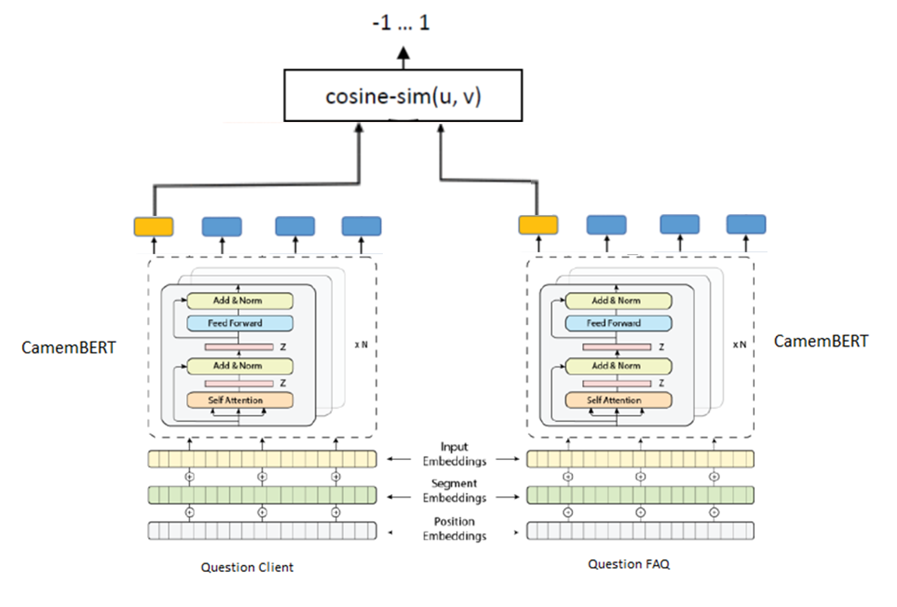

In [ ]:
class CamemBERTModel(nn.Module):
  def __init__(self):
    super(CamemBERTModel, self).__init__()
    self.camembert = Config.MODEL
    self.camembert_drop = nn.Dropout(0.2)

  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.camembert(input_ids=input_ids, attention_mask=attention_mask)
    
    # Dropout pour éviter le overfitting
    #out = self.camembert_drop(pooled_output)
     
    return pooled_output

In [ ]:
class SiameseCamemBERT(nn.Module):
    def __init__(self):
        super(SiameseCamemBERT, self).__init__()

        self.encoder = CamemBERTModel()
        self.cos = nn.CosineSimilarity(dim=1)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        # input one by one        
      sent1 = self.encoder(input_ids=input_ids1, attention_mask=attention_mask1)
      sent2 = self.encoder(input_ids=input_ids2, attention_mask=attention_mask2)
  
      output = self.cos(sent1, sent2)

      return output

### Engine

In [ ]:
def loss_fn(outputs, labels):
  return nn.MSELoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids1 = d["input_ids1"]
    attention_mask1 = d["attention_mask1"]
    input_ids2 = d["input_ids2"]
    attention_mask2 = d["attention_mask2"]
    labels = d["labels"]

    input_ids1 = input_ids1.to(device, dtype=torch.long)
    attention_mask1 = attention_mask1.to(device, dtype=torch.long)
    input_ids2 = input_ids2.to(device, dtype=torch.long)
    attention_mask2 = attention_mask2.to(device, dtype=torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids1=input_ids1, attention_mask1=attention_mask1, input_ids2=input_ids2, attention_mask2=attention_mask2)
    loss = loss_fn(outputs, labels)
    
    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids1 = d["input_ids1"]
      attention_mask1 = d["attention_mask1"]
      input_ids2 = d["input_ids2"]
      attention_mask2 = d["attention_mask2"]
      labels = d["labels"]

      input_ids1 = input_ids1.to(device, dtype=torch.long)
      attention_mask1 = attention_mask1.to(device, dtype=torch.long)
      input_ids2 = input_ids2.to(device, dtype=torch.long)
      attention_mask2 = attention_mask2.to(device, dtype=torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids1=input_ids1, attention_mask1=attention_mask1, input_ids2=input_ids2, attention_mask2=attention_mask2)
      
      loss = loss_fn(outputs, labels)
      final_loss += loss.item()
      
      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
      

  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

### Train

In [ ]:
# Read the Dataset
df_train = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_valid = test_samples

# Reset the indx
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

# Train Dataset Customisation 
train_dataset = STS(
                      sent1=df_train.sentence1.values, 
                      sent2=df_train.sentence2.values, 
                      label=df_train.similarity_score.values)

# Validation Dataset Customisation
valid_dataset = STS(
                      sent1=df_valid.sentence1.values, 
                      sent2=df_valid.sentence2.values, 
                      label=df_valid.similarity_score.values)

# Data Loader

train_dataloader = DataLoader(
                                train_dataset, 
                                batch_size=Config.TRAIN_BATCH_SIZE, 
                                num_workers=4)


valid_dataloader = DataLoader(
                                valid_dataset, 
                                batch_size=Config.VALID_BATCH_SIZE, 
                                num_workers=1)

model = SiameseCamemBERT()
model.to(Config.DEVICE)

# Optimizer
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]


optimizer = AdamW(optimizer_parameters, lr=3e-5)

num_train_steps = int(len(df_train) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)


'''optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  correct_bias = False) # We chose to correct bias'''
               
scheduler = get_linear_schedule_with_warmup(
                                              optimizer, 
                                              num_warmup_steps=0, 
                                              num_training_steps=num_train_steps)

In [ ]:
history = defaultdict(list)
best_accuracy_valid = 0

for epoch in range(1, 6):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)

  train_pearson_corr = scipy.stats.pearsonr(train_labels, train_outputs)[0]
  valid_pearson_corr= scipy.stats.pearsonr(valid_labels, valid_outputs)[0]

  print(train_labels), print(train_outputs)

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train pearson Correlation: {train_pearson_corr} \nValid Loss: {valid_loss} - Valid pearson Correlation: {valid_pearson_corr}\n")
  
  history['Train Loss'].append(train_loss)

  history['Valid Loss'].append(valid_loss)

  history['Train Pearson correlation'].append(train_pearson_corr)
  history['Valid Pearson correlation'].append(valid_pearson_corr)

  if best_accuracy_valid < valid_pearson_corr :
    torch.save(model.state_dict(), Config.MODEL_PATH)
    best_accuracy_valid = valid_pearson_corr



100%|██████████| 345/345 [00:09<00:00, 38.08it/s]


[1.0, 0.7599999904632568, 0.7599999904632568, 0.5199999809265137, 0.8500000238418579, 0.8500000238418579, 0.10000000149011612, 0.3199999928474426, 0.4399999976158142, 1.0, 0.8399999737739563, 0.9199999570846558, 0.7734000086784363, 0.9333999752998352, 0.33340001106262207, 0.75, 1.0, 0.10000000149011612, 0.7599999904632568, 1.0, 0.6399999856948853, 0.5600000023841858, 0.9199999570846558, 0.6000000238418579, 1.0, 0.9600000381469727, 1.0, 0.8399999737739563, 0.8399999737739563, 0.800000011920929, 0.800000011920929, 0.9817999601364136, 0.6000000238418579, 0.48000001907348633, 0.8399999737739563, 0.6800000071525574, 1.0, 0.75, 0.550000011920929, 1.0, 0.800000011920929, 0.7199999690055847, 0.3199999928474426, 0.3499999940395355, 1.0, 0.20000000298023224, 0.20000000298023224, 0.4749999940395355, 0.7599999904632568, 0.6399999856948853, 0.6399999856948853, 0.8799999952316284, 0.75, 0.949999988079071, 0.6399999856948853, 0.31119999289512634, 0.7875999808311462, 1.0, 1.0, 0.800000011920929, 0.319

100%|██████████| 345/345 [00:09<00:00, 37.53it/s]


[1.0, 0.7599999904632568, 0.7599999904632568, 0.5199999809265137, 0.8500000238418579, 0.8500000238418579, 0.10000000149011612, 0.3199999928474426, 0.4399999976158142, 1.0, 0.8399999737739563, 0.9199999570846558, 0.7734000086784363, 0.9333999752998352, 0.33340001106262207, 0.75, 1.0, 0.10000000149011612, 0.7599999904632568, 1.0, 0.6399999856948853, 0.5600000023841858, 0.9199999570846558, 0.6000000238418579, 1.0, 0.9600000381469727, 1.0, 0.8399999737739563, 0.8399999737739563, 0.800000011920929, 0.800000011920929, 0.9817999601364136, 0.6000000238418579, 0.48000001907348633, 0.8399999737739563, 0.6800000071525574, 1.0, 0.75, 0.550000011920929, 1.0, 0.800000011920929, 0.7199999690055847, 0.3199999928474426, 0.3499999940395355, 1.0, 0.20000000298023224, 0.20000000298023224, 0.4749999940395355, 0.7599999904632568, 0.6399999856948853, 0.6399999856948853, 0.8799999952316284, 0.75, 0.949999988079071, 0.6399999856948853, 0.31119999289512634, 0.7875999808311462, 1.0, 1.0, 0.800000011920929, 0.319

100%|██████████| 345/345 [00:09<00:00, 37.40it/s]

[1.0, 0.7599999904632568, 0.7599999904632568, 0.5199999809265137, 0.8500000238418579, 0.8500000238418579, 0.10000000149011612, 0.3199999928474426, 0.4399999976158142, 1.0, 0.8399999737739563, 0.9199999570846558, 0.7734000086784363, 0.9333999752998352, 0.33340001106262207, 0.75, 1.0, 0.10000000149011612, 0.7599999904632568, 1.0, 0.6399999856948853, 0.5600000023841858, 0.9199999570846558, 0.6000000238418579, 1.0, 0.9600000381469727, 1.0, 0.8399999737739563, 0.8399999737739563, 0.800000011920929, 0.800000011920929, 0.9817999601364136, 0.6000000238418579, 0.48000001907348633, 0.8399999737739563, 0.6800000071525574, 1.0, 0.75, 0.550000011920929, 1.0, 0.800000011920929, 0.7199999690055847, 0.3199999928474426, 0.3499999940395355, 1.0, 0.20000000298023224, 0.20000000298023224, 0.4749999940395355, 0.7599999904632568, 0.6399999856948853, 0.6399999856948853, 0.8799999952316284, 0.75, 0.949999988079071, 0.6399999856948853, 0.31119999289512634, 0.7875999808311462, 1.0, 1.0, 0.800000011920929, 0.319


100%|██████████| 345/345 [00:09<00:00, 35.73it/s]

[1.0, 0.7599999904632568, 0.7599999904632568, 0.5199999809265137, 0.8500000238418579, 0.8500000238418579, 0.10000000149011612, 0.3199999928474426, 0.4399999976158142, 1.0, 0.8399999737739563, 0.9199999570846558, 0.7734000086784363, 0.9333999752998352, 0.33340001106262207, 0.75, 1.0, 0.10000000149011612, 0.7599999904632568, 1.0, 0.6399999856948853, 0.5600000023841858, 0.9199999570846558, 0.6000000238418579, 1.0, 0.9600000381469727, 1.0, 0.8399999737739563, 0.8399999737739563, 0.800000011920929, 0.800000011920929, 0.9817999601364136, 0.6000000238418579, 0.48000001907348633, 0.8399999737739563, 0.6800000071525574, 1.0, 0.75, 0.550000011920929, 1.0, 0.800000011920929, 0.7199999690055847, 0.3199999928474426, 0.3499999940395355, 1.0, 0.20000000298023224, 0.20000000298023224, 0.4749999940395355, 0.7599999904632568, 0.6399999856948853, 0.6399999856948853, 0.8799999952316284, 0.75, 0.949999988079071, 0.6399999856948853, 0.31119999289512634, 0.7875999808311462, 1.0, 1.0, 0.800000011920929, 0.319


100%|██████████| 345/345 [00:09<00:00, 36.89it/s]

[1.0, 0.7599999904632568, 0.7599999904632568, 0.5199999809265137, 0.8500000238418579, 0.8500000238418579, 0.10000000149011612, 0.3199999928474426, 0.4399999976158142, 1.0, 0.8399999737739563, 0.9199999570846558, 0.7734000086784363, 0.9333999752998352, 0.33340001106262207, 0.75, 1.0, 0.10000000149011612, 0.7599999904632568, 1.0, 0.6399999856948853, 0.5600000023841858, 0.9199999570846558, 0.6000000238418579, 1.0, 0.9600000381469727, 1.0, 0.8399999737739563, 0.8399999737739563, 0.800000011920929, 0.800000011920929, 0.9817999601364136, 0.6000000238418579, 0.48000001907348633, 0.8399999737739563, 0.6800000071525574, 1.0, 0.75, 0.550000011920929, 1.0, 0.800000011920929, 0.7199999690055847, 0.3199999928474426, 0.3499999940395355, 1.0, 0.20000000298023224, 0.20000000298023224, 0.4749999940395355, 0.7599999904632568, 0.6399999856948853, 0.6399999856948853, 0.8799999952316284, 0.75, 0.949999988079071, 0.6399999856948853, 0.31119999289512634, 0.7875999808311462, 1.0, 1.0, 0.800000011920929, 0.319

### Error Analysis & Performance auditing

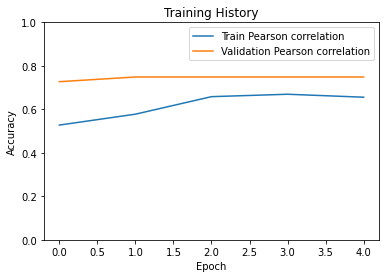

In [ ]:
plt.plot(history['Train Pearson correlation'], label='Train Pearson correlation')
plt.plot(history['Valid Pearson correlation'], label='Validation Pearson correlation')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

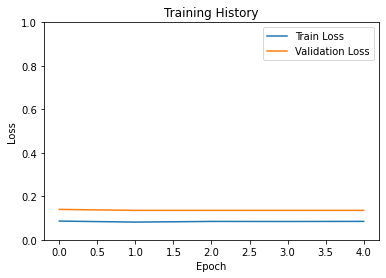

In [ ]:
plt.plot(history['Train Loss'], label='Train Loss')
plt.plot(history['Valid Loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Inference

In [ ]:
model = SiameseCamemBERT()
model.to(Config.DEVICE)
model.load_state_dict(
    torch.load(
        Config.MODEL_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids1, attention_mask1, input_ids2, attention_mask2 = data.preprocess_bert()
  
  input_ids1 = input_ids1.to(Config.DEVICE, dtype=torch.long)
  attention_mask1 = attention_mask1.to(Config.DEVICE, dtype=torch.long)
  input_ids2 = input_ids2.to(Config.DEVICE, dtype=torch.long)
  attention_mask2 = attention_mask2.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
  similarity_score = data.preprocess_output(outputs) 
  
  return {
      "sentence1": sent1,
      "sentence2": sent2,
      "similarity Score": str(similarity_score)
      #"no similarity Score": str(no_similarity_Score),
  }

In [ ]:
sentence1 = "Trois hommes jouent aux échecs."
sentence2 = "Deux hommes jouent aux échecs."

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'Trois hommes jouent aux échecs.', 'sentence2': 'Deux hommes jouent aux échecs.', 'similarity Score': '[0.90177697]'}


In [ ]:
sentence1 = "je suis heureux"
sentence2 = "je suis triste"

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'je suis heureux', 'sentence2': 'je suis triste', 'similarity Score': '[0.86907953]'}


Inference : FAQ CMR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
faq = pd.read_excel('/content/drive/MyDrive/FAQ-CMR.xlsx')
faq.head()

,Question,Réponse,Catégorie
0,"Je suis un fonctionnaire, comment m’affilier a...",Vous n'avez aucune démarche à faire pour cette...,Affiliation
1,J’étais un agent dans une collectivité territo...,"Oui, toutefois, vous devez informer votre Adm...",Affiliation
2,La date de naissance portée sur mon attestatio...,"En cas de discordance, merci de contacter votr...",Affiliation
3,Quelles sont les conditions nécessaires pour l...,Tous les affiliés aux régimes de base de gérés...,Attakmili
4,Quel est la cotisation minimale au titre du Ré...,La cotisation minimale est de 50 DHS,Attakmili


In [ ]:
query = "est ce qu'il y a une possibilté pour modifier le prénom ?"

def predict_(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids1, attention_mask1, input_ids2, attention_mask2 = data.preprocess_bert()
  
  input_ids1 = input_ids1.to(Config.DEVICE, dtype=torch.long)
  attention_mask1 = attention_mask1.to(Config.DEVICE, dtype=torch.long)
  input_ids2 = input_ids2.to(Config.DEVICE, dtype=torch.long)
  attention_mask2 = attention_mask2.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
  similarity_score = data.preprocess_output(outputs)
  return similarity_score

question=[]
scores = []
for idx in range(faq.shape[0]):
  score = predict_(query,str(faq['Question'][idx]))[0]
  scores.append(score)
  question.append(faq['Question'][idx])
  


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [ ]:
df = pd.DataFrame(list(zip(question, scores)),
               columns =['Question', 'similarity_score'])
df.sort_values(by='similarity_score', axis=0, ascending=False).head(5)

,Question,similarity_score
28,Comment faut-il procéder pour rectifier mon nom?,0.708274
29,Comment faut-il procéder pour changer mon nom ?,0.675561
65,Comment faut-il procéder pour demander la radiation d’un enfant décédé ?,0.613605
77,Faut-il envoyer les documents relatifs au contrôle de maintien de droit d’une manière automatique à la CMR ?,0.608323
27,Comment faut-il procéder pour inscrire de nouvelles naissances ?,0.586715


In [ ]:
query1= "Quels sont les document nécessaire pour un dossier d'allocations en cas de divorce "
question1=[]
scores1 = []
for idx in range(faq.shape[0]):
  score = predict_(query1,str(faq['Question'][idx]))[0]
  scores1.append(score)
  question1.append(faq['Question'][idx])

In [ ]:
df = pd.DataFrame(list(zip(question1, scores1)),
               columns =['Question', 'similarity_score'])
df.sort_values(by='similarity_score', axis=0, ascending=False).head(5)

,Question,similarity_score
66,Je suis une femme divorcée. Quelles sont les pièces à fournir pour constituer mon dossier d’allocations familiales,0.785315
61,Quel est l’âge limite pour bénéficier des allocations familiales ?,0.731373
62,Quel est le montant des allocations familiales ?,0.672969
77,Faut-il envoyer les documents relatifs au contrôle de maintien de droit d’une manière automatique à la CMR ?,0.667784
69,Quelles sont les conditions d’octroi du droit à pension de retraite d’ayants cause ?,0.659404


In [ ]:
query2= "j'ai deux bébé, l'un est handicapé et l'autre normal, quelles sont les procédures ? "
question2=[]
scores2 = []
for idx in range(faq.shape[0]):
  score = predict_(query2,str(faq['Question'][idx]))[0]
  scores2.append(score)
  question2.append(faq['Question'][idx])

df = pd.DataFrame(list(zip(question2, scores2)),
               columns =['Question', 'similarity_score'])
df.sort_values(by='similarity_score', axis=0, ascending=False).head(5)

,Question,similarity_score
26,ِComment faut-il procéder pour inscrire des enfants handicapés ?,0.692063
64,Que dois-je faire pour continuer à percevoir les allocations des enfants infirmes ?,0.628399
37,Je suis orphelin(e) handicapé(e je voudrai bénéficier de la réversion de la pension de retraite. Quelles sont les pièces que je dois fournir à la CMR ?,0.593175
61,Quel est l’âge limite pour bénéficier des allocations familiales ?,0.591563
34,"Je suis orphelin(e) handicapé(e), je voudrai bénéficier de la réversion de la pension d’invalidité. Quelles sont les pièces que je dois fournir à la CMR ?",0.586581


### References
* **Louis Martin, Benjamin Muller, Pedro Javier Ortiz Suárez, Yoann Dupont, Laurent Romary, Éric Villemonte de la Clergerie, Djamé Seddah, Benoît Sagot. 2019. [CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894). arXiv preprint arXiv:1911.03894**